In [158]:
import numpy as np
import datetime as dt
from astropy import units as u
from astropy.coordinates import Angle
from astropy.coordinates import Longitude
import pint as pt
from pint import UnitRegistry
import scipy.optimize
import emcee
import ephem
import math

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

ImportError: No module named 'mpl_toolkits.basemap'

In [2]:
a = Longitude('-20d')+Longitude('-355d')
print(a)
ureg = UnitRegistry()
ureg.Quantity(10.0,ureg.degC)
ureg.Quantity(10.0,ureg.mbar)

345d00m00s


<Quantity(10.0, 'millibar')>

In [166]:
def compute_Hc(latA, lonA, GHA, DEC):
    # compute LHA from GHA and lonA
    LHA = GHA + lonA
    Hc_rad = np.arcsin(np.sin(DEC.radian)*np.sin(latA.radian) + np.cos(latA.radian)*np.cos(DEC.radian)*np.cos(LHA.radian))
    return Angle(Hc_rad, unit=u.radian)


def dip_correction(h):
    dip_corr = Angle(-0.0293*np.sqrt(h.to_base_units().magnitude), unit=u.deg)
    return dip_corr

def index_correction(IE):
    return -1*IE

def atmo_correction(Ha, T, P):
    ureg = UnitRegistry()
    Pmb = P.to(ureg.mbar)
    TdegC = T.to(ureg.degC)

    f = 0.28*Pmb.magnitude/(TdegC.magnitude + 273)
    Ro = -0.0167/np.tan(np.pi/180.0*(Ha.deg + 7.31/(Ha.deg + 4.4)))
    return Angle(Ro*f,unit=u.deg)

def dead_reckon(lat_init, lon_init, DRv, DRheading, time):
    # compute lat velocity
    lat_v = DRv*np.sin(DRheading.radian)
    lon_v = DRv*np.cos(DRheading.radian)/np.cos(lat_init.radian) # corrects for lattitude
    # now increment linearly based on time
    return lat_init + lat_v*time, lon_init + lon_v*time

def est_longitude(body, date, time, Hs, IE, h, temp, pressure, GHA, DEC, latA, lonA):
    # use a root-finding algorithm to compute the longitude based on an
    # assumed latitude. here, the estimated longitude is to start the root-finding algorithm
    print(repr(Hs))

    est_true_H = (Hs.deg + dip_correction(h).deg + index_correction(IE).deg + atmo_correction(Hs, temp, pressure).deg + semidiameter_correction(body, date, time).deg)
    print('Finding Zo for true sextant angle of ' + '{:.3f}'.format(est_true_H) + ' degrees...')
    
    start_H = compute_Hc(latA, lonA, GHA, DEC).deg
    lower_H = compute_Hc(latA, Angle(lonA.deg-2,unit=u.deg), GHA, DEC).deg
    
    upper_H = compute_Hc(latA, Angle(lonA.deg+2,unit=u.deg), GHA, DEC).deg
    
    print('Starting from value ' + '{:.3f}'.format(start_H) + ' degrees, with lower {:.3f} and upper {:.3f}.'.format(lower_H,upper_H))
    
    fz = lambda x: (compute_Hc(latA, Angle(x,unit=u.deg), GHA, DEC).deg - (Hs.deg + dip_correction(h).deg + index_correction(IE).deg + atmo_correction(Hs, temp, pressure).deg + semidiameter_correction(body, date, time).deg))
    #print('fz(a) is {:.3f}, fz(b) is {:.3f}'.format(fz(lonA.deg-2),fz(lonA.deg+2)))
    #spn_out = scipy.optimize.newton(fz, lonA.deg, maxiter=200)
    sp_out = scipy.optimize.brentq(fz, lonA.deg-2.0, lonA.deg+2.0,maxiter=100)
    
    #sp_out = scipy.optimize.minimize_scalar(fz, bracket=[lonA.deg-2.0,lonA.deg+2.0], method='brent', tol=1.48e-06)
    
    return Angle(spn_out, unit=u.deg)

def Hs_predict(times, IE, h, temp, pressure, GHA, DEC, DRv, DRheading, latA, lonA):
    '''
    times -- numpy array of time values in seconds, starting with 0.0 always
    
    
    '''
    
    Hc = compute_Hc(latA, lonA, GHA, DEC)
    est_Hs = (Hc.deg - dip_correction(h).deg - index_correction(IE).deg - atmo_correction(Hc, temp, pressure).deg - semidiameter_correction(body, date, time).deg)
    return est_Hs


5


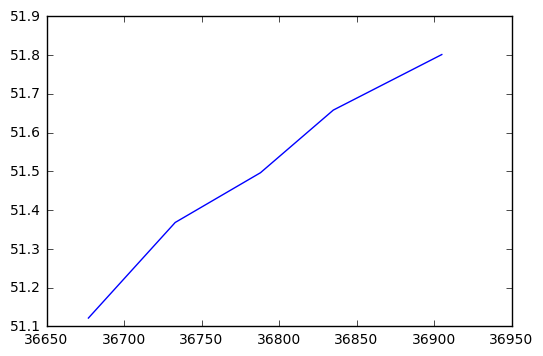

In [7]:
#plot run of sun sights


sun_sights = [
    [10*3600+11*60+17.0, Angle('51d07.3m')],
    [10*3600+12*60+13, Angle('51d22.1m')],
    [10*3600.0+13*60+8, Angle('51d29.8m')],
    [10*3600.0+13*60+55.0, Angle('51d39.5m')],
    [10*3600+15*60+5.0, Angle('51d48.1m')]
]
print(len(sun_sights))
# process list into 2d array

sun_sights_processed = np.zeros((len(sun_sights),2))
for i in range(len(sun_sights)):
    sun_sights_processed[i,0] = sun_sights[i][0]
    sun_sights_processed[i,1] = sun_sights[i][1].deg
    
plt.plot(sun_sights_processed[:,0],sun_sights_processed[:,1])
plt.show()

In [167]:
# 'database' of sightings for reduction into a single lat/long pair + course speed/heading

db_sights = """\
SunLL,2015/02/22,12:11:17,51d07.3m,0.0,2.0m,2.44,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,12:12:13,51d22.1m,0.0,2.0m,2.44,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,12:13:08,51d29.8m,0.0,2.0m,2.44,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,12:13:55,51d39.5m,0.0,2.0m,2.44,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,12:15:05,51d39.5m,0.0,2.0m,2.44,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,14:21:17,62d42.3m,0.0,2.1m,3.05,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,14:22:23,62d34.8m,0.0,2.1m,3.05,25,1010,5.5,180d,16d44m,-27d7m
SunLL,2015/02/22,14:23:11,62d36.4m,0.0,2.1m,3.05,25,1010,5.5,180d,16d44m,-27d7m
"""

db_sights_split = db_sights.split('\n')
# remove last element
del db_sights_split[-1]

def nadeg(deg):
    #changes ephem.angel (rad) to the format for the Angle class.
    theminus = ""
    if deg < 0:
    	theminus = "-"
    g = int(math.degrees(deg))
    m = (math.degrees(deg)-g)*60
    gm = "%s%sd%04.1fm" %(theminus,abs(g),abs(m))
    return gm

def compute_GHA_DEC(body, date, time):
    if body == 'SunLL' or 'SunUL':
        s = ephem.Sun()
        obs = ephem.Observer()
        date_string = date + ' ' + time
        obs.date = date_string
        
        s.compute(date_string,epoch=date_string)

        deg = ephem.degrees(obs.sidereal_time()-s.g_ra).norm
        ghas = nadeg(deg)
        deg = s.g_dec
        decs = nadeg(deg)

    return Angle(ghas,unit=u.deg), Angle(decs,unit=u.deg)

def semidiameter_correction(body, date, time):
    if body == 'SunLL' or 'SunUL':
        s = ephem.Sun()
        obs = ephem.Observer()
        date_string = date + ' ' + time
        obs.date = date_string
        
        s.compute(date_string,epoch=date_string)
        # compute SD of sun
        sds = s.radius/ephem.pi*180.0 # degrees of arc
        if body == 'SunLL':
            return Angle('{:.3f}d'.format(sds))
        else:
            return Angle('{:.3f}d'.format(sds))
        
    return Angle('0d')
        
ll_lat = []
ll_lon = []
# preprocess the array of sights into corrected sightings based on ephemeris from pyephem
for i in range(len(db_sights_split)):
    ureg = UnitRegistry()
    
    body, date, time, Hs, WE, IE, height, temp, pressure, DRv, DRheading, latA, lonA = db_sights_split[i].split(',') # split into line elements
    # coerce values from strings to objects
    # ignores watch error (WE)
    Hs = Angle(Hs)
    WE = float(WE)
    IE = Angle(IE)
    height = float(height)*ureg.meter
    pressure = ureg.Quantity(float(pressure),ureg.mbar)
    temp = ureg.Quantity(float(temp),ureg.degC)
    DRv = float(DRv)
    DRheading = Angle(DRheading,unit=u.deg) # FIX THIS TO APPROPRIATE COORDINATES
    latA = Angle(latA,unit=u.deg)
    lonA = Angle(lonA,unit=u.deg)
    
    # process based on body
    if body == 'SunLL':
        GHAc, DECc = compute_GHA_DEC(body, date, time)
        sd = semidiameter_correction(body, date, time)
        print('date: {}'.format(date + ' ' + time))
        print('GHA: {}, DEC: {}'.format(GHAc, DECc))
        
    
    # estimate the location
    # function def is: est_longitude(body, date, time, Ha, IE, h, temp, pressure, GHA, DEC, latA, lonA):
    est_long = est_longitude(body, date, time, Hs, IE, height, temp, pressure, GHAc, DECc, latA, lonA)
    print('Estimated longitude is: {:.3f}'.format(est_long))
    ll_lat.append(i)
    ll_lon.append(est_long.deg)
    
    # now process the sightings again into corrected sightings and the GHA/DEC values
    
    
# m = Basemap(projection='merc',llcrnrlat=20,urcrnrlat=50,\
#             llcrnrlon=-130,urcrnrlon=-60,lat_ts=20,resolution='i')
# m.drawcoastlines()
# m.drawcountries()
# # draw parallels and meridians.
# parallels = np.arange(-90.,91.,5.)
# # Label the meridians and parallels
# m.drawparallels(parallels,labels=[False,True,True,False])
# # Draw Meridians and Labels
# meridians = np.arange(-180.,181.,10.)
# m.drawmeridians(meridians,labels=[True,False,False,True])
# m.drawmapboundary(fill_color='white')
# plt.title("Forecast {0} days out".format(day_out))
# x,y = m(ll_lon, ll_lat)                            # This is the step that transforms the data into the map's projection


date: 2015/02/22 12:11:17
GHA: 359.44666666666666 deg, DEC: -10.205 deg
<Angle 51.12166666666667 deg>
Finding Zo for true sextant angle of 51.299 degrees...
Starting from value 51.601 degrees, with lower 50.168 and upper 52.985.
fz(a) is -1.131, fz(b) is 1.686
Estimated longitude is: -27.544 deg
date: 2015/02/22 12:12:13
GHA: 359.68 deg, DEC: -10.205 deg
<Angle 51.36833333333333 deg>
Finding Zo for true sextant angle of 51.546 degrees...
Starting from value 51.765 degrees, with lower 50.337 and upper 53.142.
fz(a) is -1.208, fz(b) is 1.597
Estimated longitude is: -27.429 deg
date: 2015/02/22 12:13:08
GHA: 359.90833333333336 deg, DEC: -10.205 deg
<Angle 51.49666666666667 deg>
Finding Zo for true sextant angle of 51.674 degrees...
Starting from value 51.925 degrees, with lower 50.503 and upper 53.296.
fz(a) is -1.171, fz(b) is 1.622
Estimated longitude is: -27.475 deg
date: 2015/02/22 12:13:55
GHA: 0.105 deg, DEC: -10.205 deg
<Angle 51.65833333333333 deg>
Finding Zo for true sextant angl

KeyboardInterrupt: 

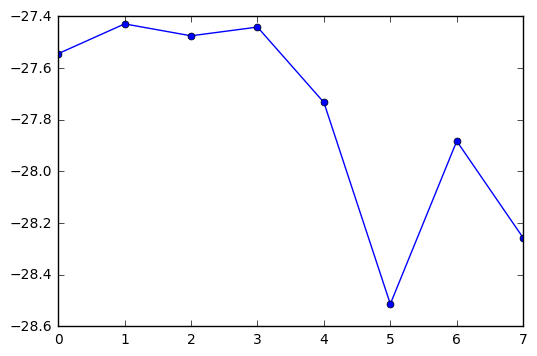

In [164]:
plt.plot(ll_lat,ll_lon, 'bo-', markersize=5)
plt.show()